Using device: cuda
Loading data...


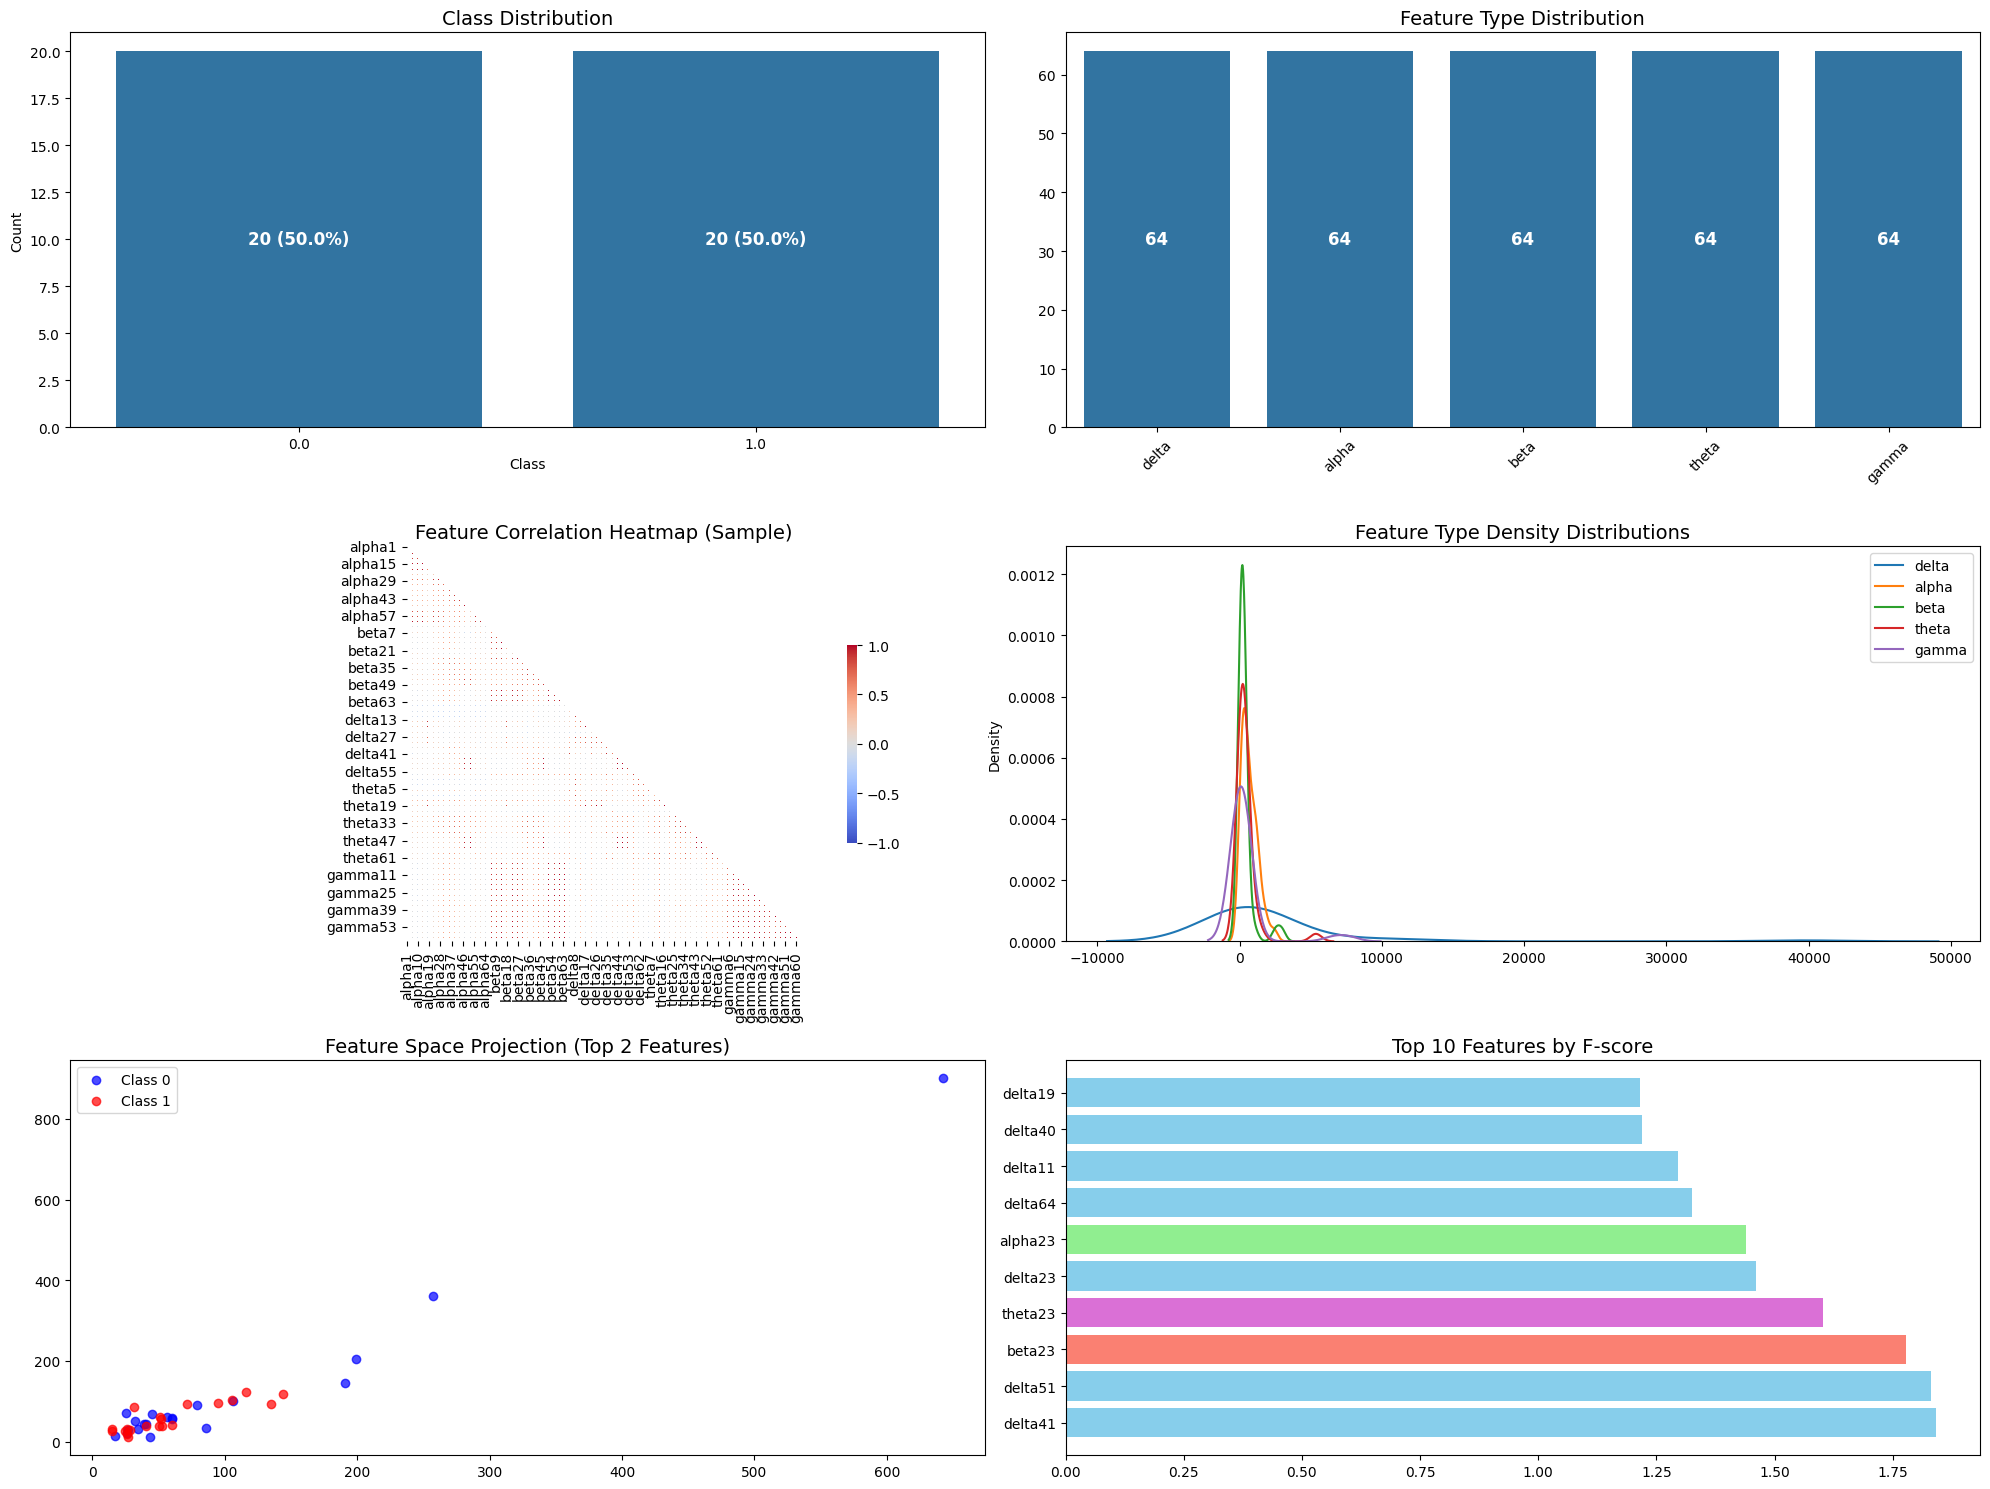

Extracting key features...

Training model 1/10
Epoch 50, Loss: 0.5541, Acc: 0.5000
Epoch 100, Loss: 0.5078, Acc: 0.5000
Epoch 150, Loss: 0.5238, Acc: 0.5000
Epoch 200, Loss: 0.5260, Acc: 0.5000

Training model 2/10
Epoch 50, Loss: 0.5572, Acc: 0.5000
Epoch 100, Loss: 0.5431, Acc: 0.5000
Epoch 150, Loss: 0.5551, Acc: 0.5000
Epoch 200, Loss: 0.5786, Acc: 0.5000

Training model 3/10
Epoch 50, Loss: 0.5820, Acc: 0.3750
Epoch 100, Loss: 0.5912, Acc: 0.3750
Epoch 150, Loss: 0.4845, Acc: 0.5000
Epoch 200, Loss: 0.4889, Acc: 0.3750

Training model 4/10
Epoch 50, Loss: 0.5029, Acc: 0.6250
Epoch 100, Loss: 0.4572, Acc: 0.6250
Epoch 150, Loss: 0.5458, Acc: 0.6250
Epoch 200, Loss: 0.6257, Acc: 0.6250

Training model 5/10
Epoch 50, Loss: 0.5171, Acc: 0.2500
Epoch 100, Loss: 0.5363, Acc: 0.6250
Epoch 150, Loss: 0.5652, Acc: 0.7500
Epoch 200, Loss: 0.6264, Acc: 0.6250

Training model 6/10
Epoch 50, Loss: 0.5533, Acc: 0.3750
Epoch 100, Loss: 0.5488, Acc: 0.3750
Epoch 150, Loss: 0.5812, Acc: 0.3750
Ep

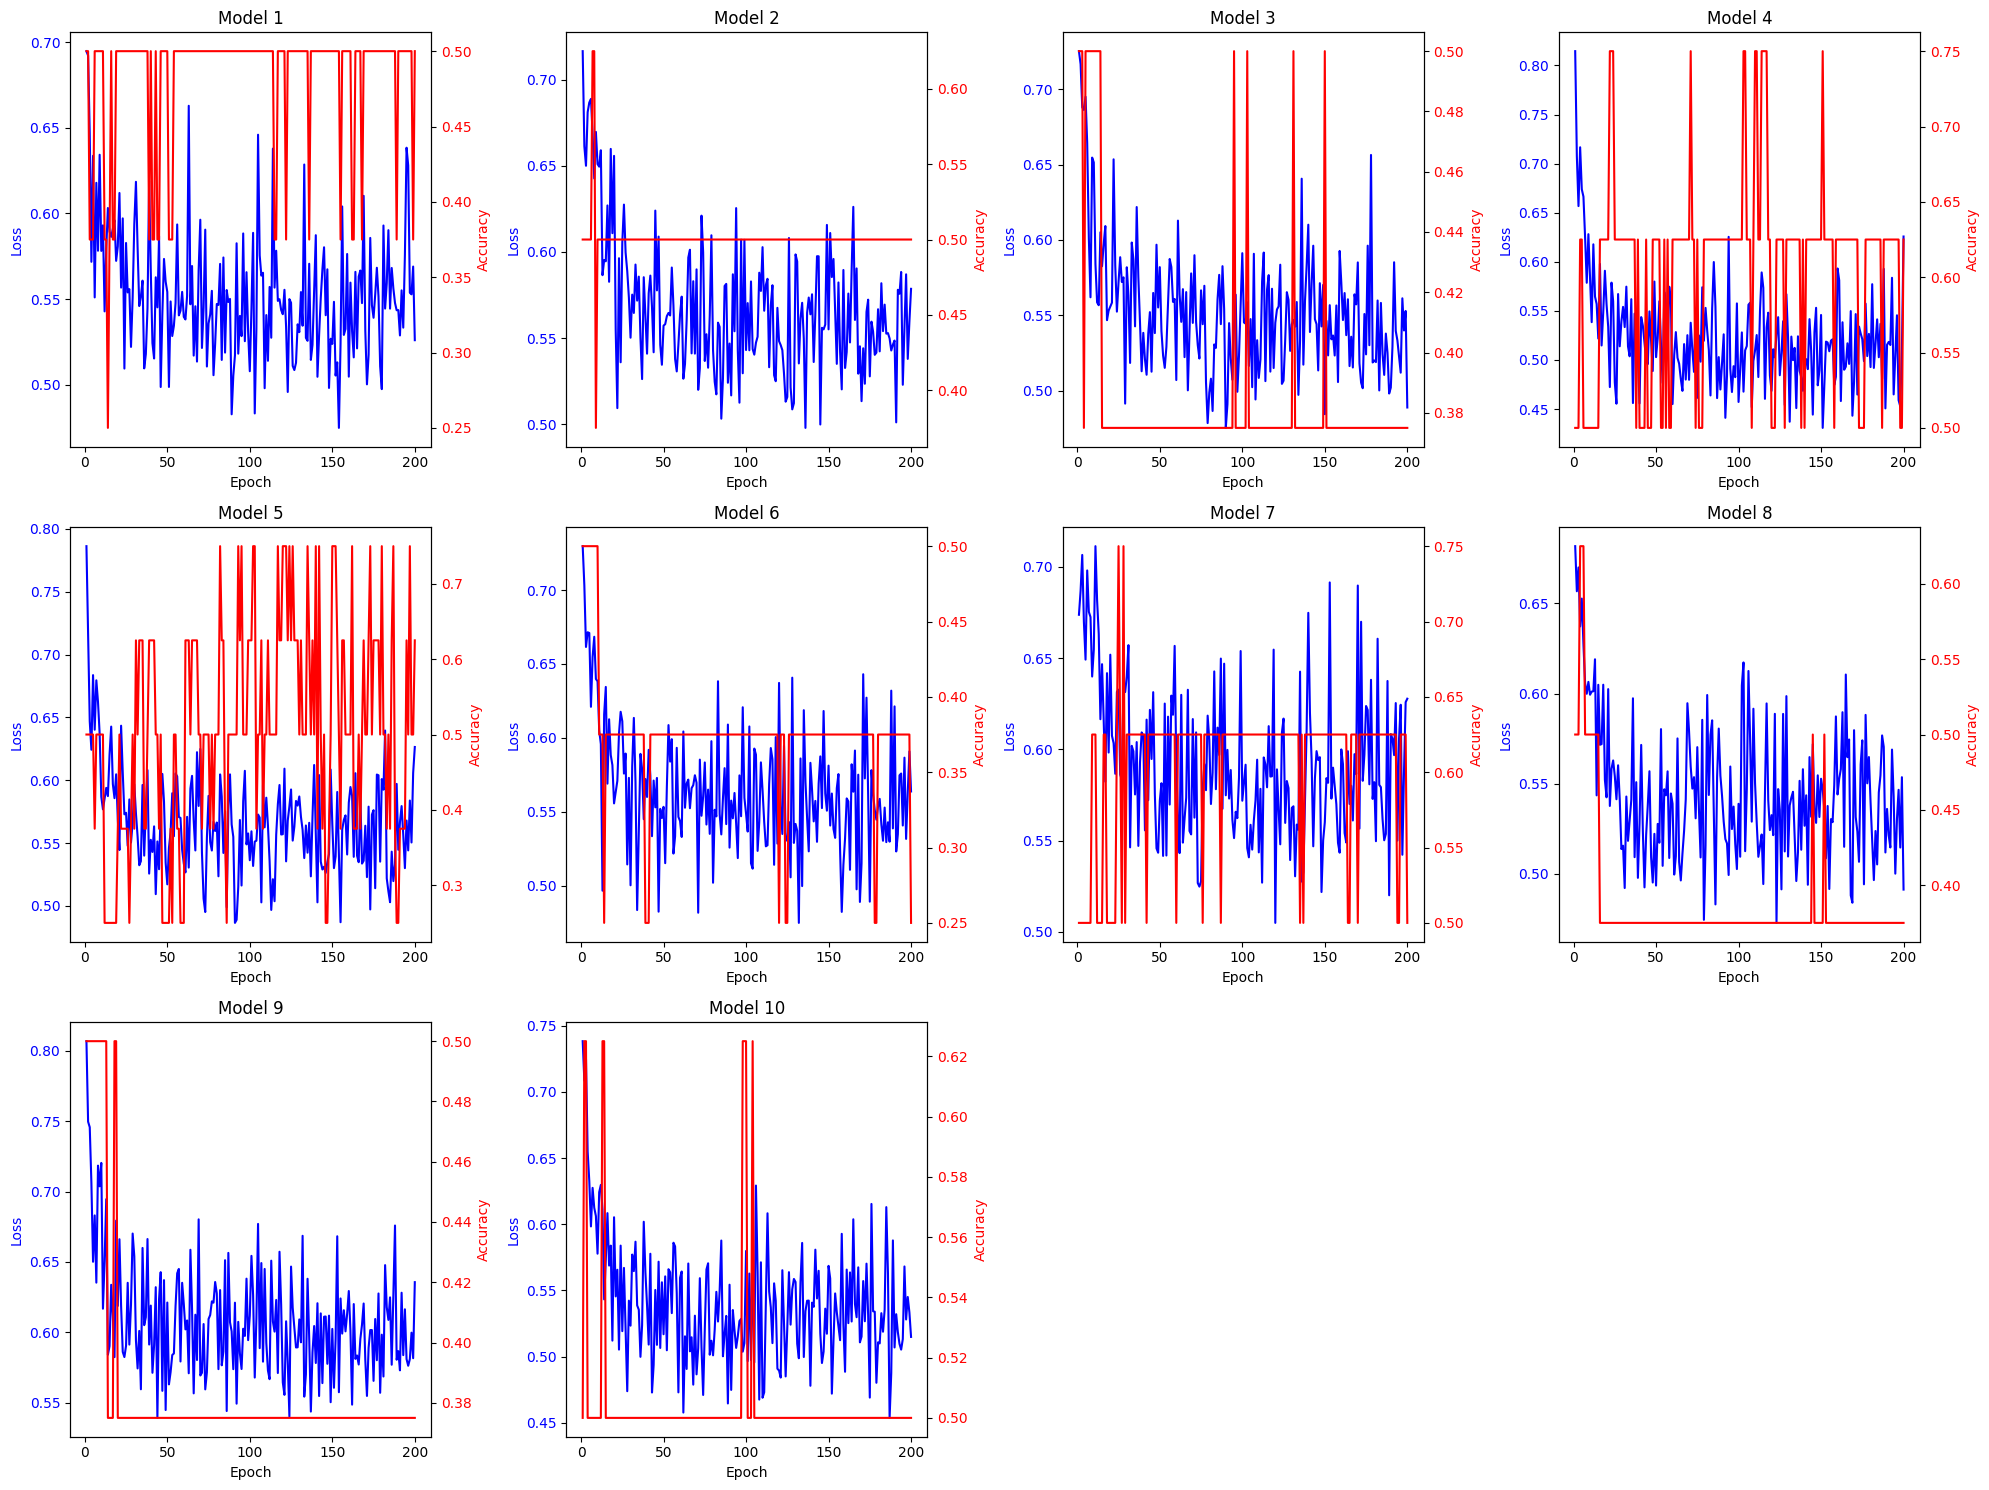


Optimizing ensemble threshold...


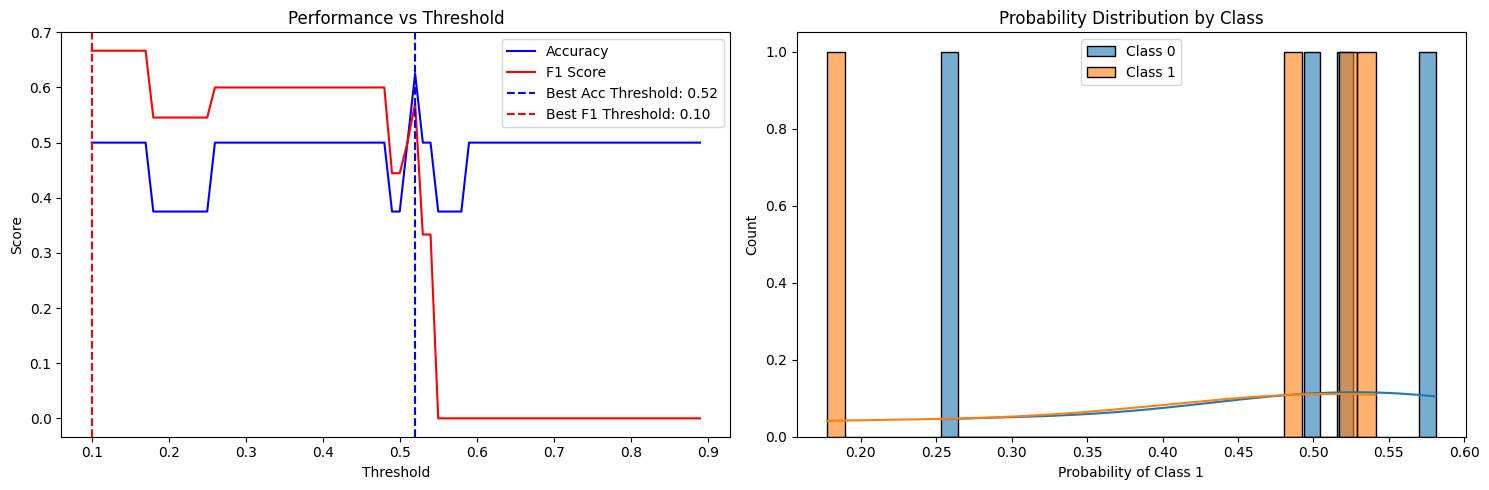


Best threshold: 0.52
Test Accuracy: 0.6250
Test F1 Score: 0.5714


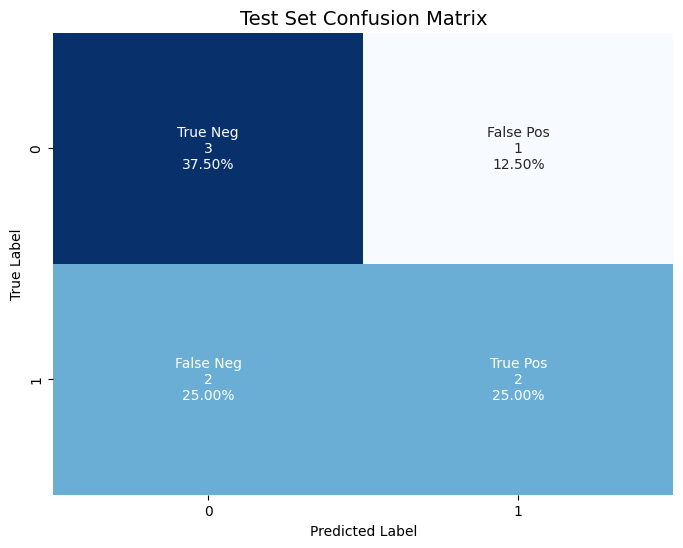

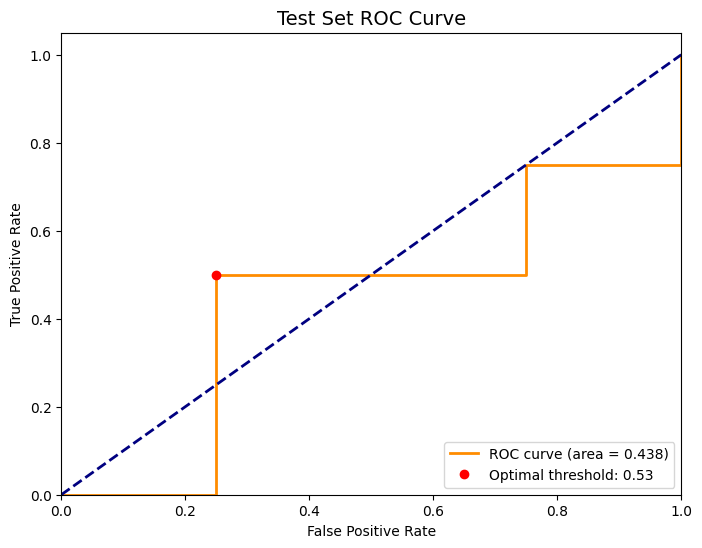

AUC Score: 0.4375


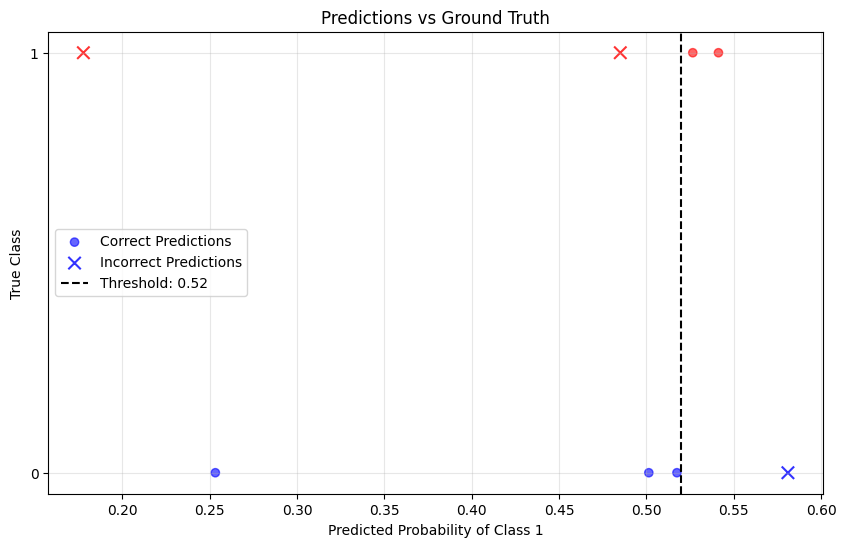


Applying ensemble to full dataset...

Full Dataset Results:
Accuracy: 0.7250
F1 Score: 0.7027


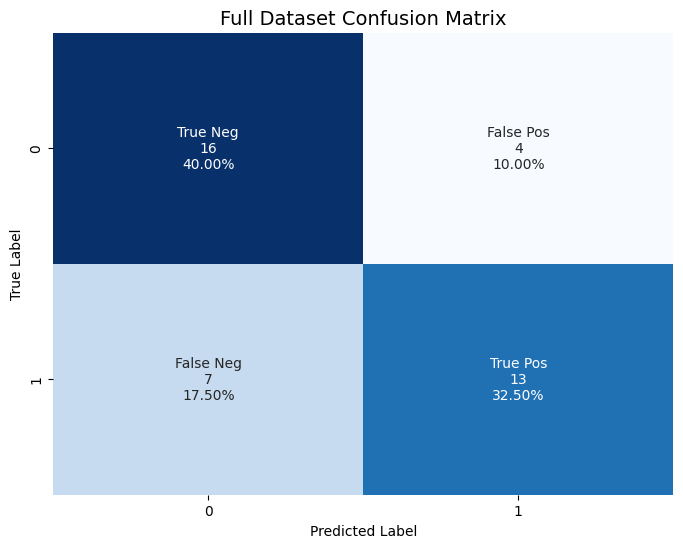

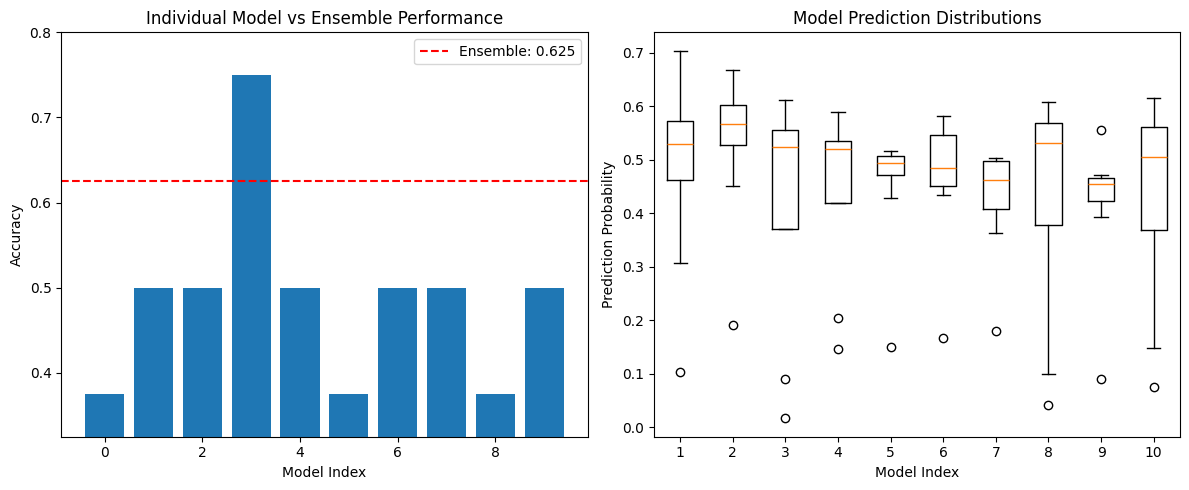


Performing cross-validation...
Fold 1/5
  Accuracy: 0.2500, F1: 0.2500, AUC: 0.3125
Fold 2/5
  Accuracy: 0.5000, F1: 0.5000, AUC: 0.4375
Fold 3/5
  Accuracy: 0.6250, F1: 0.5714, AUC: 0.6250
Fold 4/5
  Accuracy: 0.3750, F1: 0.0000, AUC: 0.1250
Fold 5/5
  Accuracy: 0.2500, F1: 0.0000, AUC: 0.3750

Cross-validation results:
Accuracy: 0.4000 ± 0.1458
F1 score: 0.2643 ± 0.2407
AUC: 0.3750 ± 0.1630


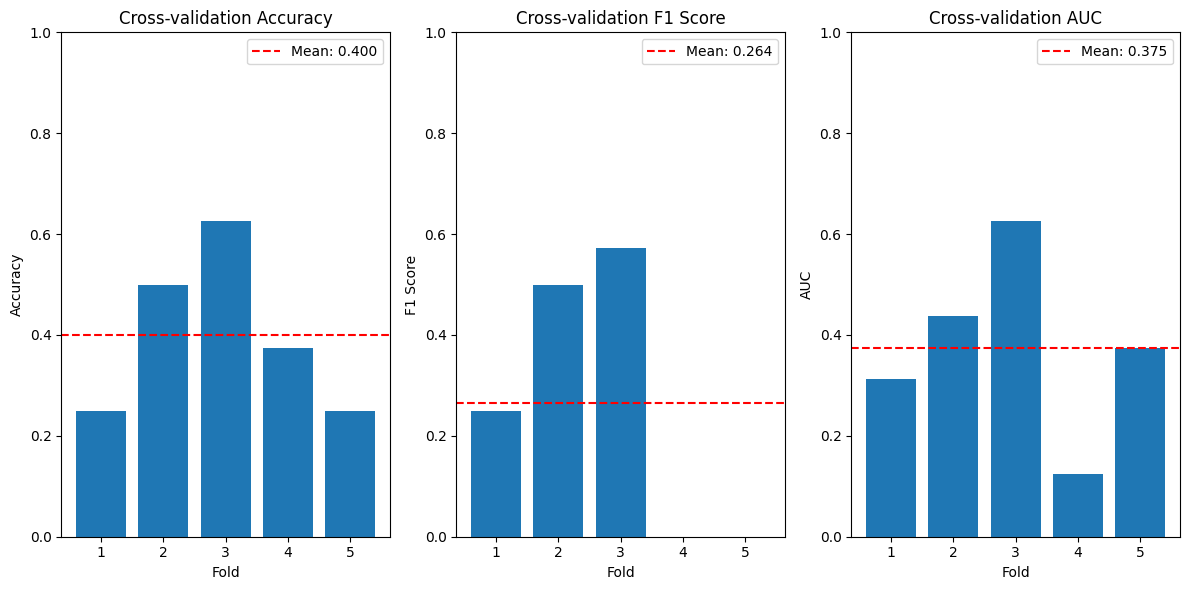


Total execution time: 0.90 minutes
Final Accuracy: 0.7250
Final F1 Score: 0.7027


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EEGDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class DeltaFeatureModel(nn.Module):
    def __init__(self, input_size):
        super(DeltaFeatureModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.3)

        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.drop3 = nn.Dropout(0.2)

        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.drop1(x)

        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.drop2(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.drop3(x)

        return self.output(x).squeeze(1)

def extract_key_features(X, feature_names):
    delta_cols = [i for i, name in enumerate(feature_names) if 'delta' in name]
    alpha_cols = [i for i, name in enumerate(feature_names) if 'alpha' in name]
    beta_cols = [i for i, name in enumerate(feature_names) if 'beta' in name]
    theta_cols = [i for i, name in enumerate(feature_names) if 'theta' in name]
    gamma_cols = [i for i, name in enumerate(feature_names) if 'gamma' in name]

    delta_power = X[:, delta_cols].copy()
    delta_mean = np.mean(X[:, delta_cols], axis=1).reshape(-1, 1)
    delta_var = np.var(X[:, delta_cols], axis=1).reshape(-1, 1)
    delta_min = np.min(X[:, delta_cols], axis=1).reshape(-1, 1)
    delta_max = np.max(X[:, delta_cols], axis=1).reshape(-1, 1)

    alpha_mean = np.mean(X[:, alpha_cols], axis=1).reshape(-1, 1)
    beta_mean = np.mean(X[:, beta_cols], axis=1).reshape(-1, 1)
    theta_mean = np.mean(X[:, theta_cols], axis=1).reshape(-1, 1)
    gamma_mean = np.mean(X[:, gamma_cols], axis=1).reshape(-1, 1)

    delta_alpha_ratio = delta_mean / (alpha_mean + 1e-10)
    delta_beta_ratio = delta_mean / (beta_mean + 1e-10)
    delta_theta_ratio = delta_mean / (theta_mean + 1e-10)

    key_features = np.hstack([
        delta_power,
        delta_mean, delta_var, delta_min, delta_max,
        alpha_mean, beta_mean, theta_mean, gamma_mean,
        delta_alpha_ratio, delta_beta_ratio, delta_theta_ratio
    ])

    return key_features

def balance_classes(X, y):
    X_class0 = X[y == 0]
    X_class1 = X[y == 1]
    y_class0 = y[y == 0]
    y_class1 = y[y == 1]

    if len(X_class0) < len(X_class1):
        n_repeats = len(X_class1) // len(X_class0) + 1
        X_class0_upsampled = np.repeat(X_class0, n_repeats, axis=0)[:len(X_class1)]
        y_class0_upsampled = np.repeat(y_class0, n_repeats)[:len(X_class1)]
        return np.vstack([X_class0_upsampled, X_class1]), np.concatenate([y_class0_upsampled, y_class1])
    else:
        n_repeats = len(X_class0) // len(X_class1) + 1
        X_class1_upsampled = np.repeat(X_class1, n_repeats, axis=0)[:len(X_class0)]
        y_class1_upsampled = np.repeat(y_class1, n_repeats)[:len(X_class0)]
        return np.vstack([X_class0, X_class1_upsampled]), np.concatenate([y_class0, y_class1_upsampled])

def visualize_data(df, feature_cols, y):
    plt.figure(figsize=(20, 15))

    plt.subplot(3, 2, 1)
    class_counts = pd.Series(y).value_counts().sort_index()
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution', fontsize=14)
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i, count in enumerate(class_counts.values):
        plt.text(i, count/2, f'{count} ({count/len(y)*100:.1f}%)',
                 ha='center', va='center', fontsize=12, color='white', fontweight='bold')

    plt.subplot(3, 2, 2)
    feature_types = ['delta', 'alpha', 'beta', 'theta', 'gamma']
    type_counts = [sum(1 for col in feature_cols if ftype in col) for ftype in feature_types]
    sns.barplot(x=feature_types, y=type_counts)
    plt.title('Feature Type Distribution', fontsize=14)
    plt.xticks(rotation=45)
    for i, count in enumerate(type_counts):
        plt.text(i, count/2, str(count), ha='center', va='center', fontsize=12, color='white', fontweight='bold')

    plt.subplot(3, 2, 3)
    data_sample = df.iloc[:, 1:-1].sample(min(500, len(df)))
    corr_matrix = data_sample.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.title('Feature Correlation Heatmap (Sample)', fontsize=14)

    plt.subplot(3, 2, 4)
    for i, ftype in enumerate(feature_types):
        cols = [col for col in feature_cols if ftype in col]
        if cols:
            means = df[cols].mean(axis=1)
            sns.kdeplot(means, label=ftype, color=plt.cm.tab10(i))
    plt.legend()
    plt.title('Feature Type Density Distributions', fontsize=14)

    plt.subplot(3, 2, 5)
    X_embedded = SelectKBest(f_classif, k=2).fit_transform(df.iloc[:, 1:-1].values, y)
    plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], alpha=0.7, label='Class 0', color='blue')
    plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], alpha=0.7, label='Class 1', color='red')
    plt.legend()
    plt.title('Feature Space Projection (Top 2 Features)', fontsize=14)

    plt.subplot(3, 2, 6)
    feature_importance = f_classif(df.iloc[:, 1:-1].values, y)[0]
    top_indices = np.argsort(feature_importance)[-10:][::-1]
    top_feature_names = [feature_cols[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    colors = []
    for feat in top_feature_names:
        if 'delta' in feat:
            colors.append('skyblue')
        elif 'alpha' in feat:
            colors.append('lightgreen')
        elif 'beta' in feat:
            colors.append('salmon')
        elif 'theta' in feat:
            colors.append('orchid')
        elif 'gamma' in feat:
            colors.append('gold')
        else:
            colors.append('gray')

    plt.barh(range(len(top_indices)), top_importance, color=colors)
    plt.yticks(range(len(top_indices)), top_feature_names)
    plt.title('Top 10 Features by F-score', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_training_metrics(histories, title='Training Metrics'):
    n_models = len(histories)
    rows = (n_models + 3) // 4
    plt.figure(figsize=(20, 5 * rows))

    for i, history in enumerate(histories):
        plt.subplot(rows, 4, i+1)

        epochs = range(1, len(history['train_loss'])+1)
        plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')

        ax1 = plt.gca()
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2 = ax1.twinx()
        ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Acc')
        ax2.set_ylabel('Accuracy', color='r')
        ax2.tick_params(axis='y', labelcolor='r')

        plt.title(f'Model {i+1}')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title, fontsize=14)
    plt.show()

def plot_roc_curve(y_true, y_score, title='ROC Curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right")

    idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[idx]
    optimal_point = (fpr[idx], tpr[idx])
    plt.plot(optimal_point[0], optimal_point[1], 'ro',
             label=f'Optimal threshold: {optimal_threshold:.2f}')
    plt.legend(loc="lower right")

    plt.show()

    return roc_auc, optimal_threshold

def plot_threshold_analysis(probs, y_true):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    thresholds = np.arange(0.1, 0.9, 0.01)
    accuracies = []
    f1_scores = []

    for threshold in thresholds:
        preds = (probs > threshold).astype(float)
        accuracies.append(accuracy_score(y_true, preds))
        f1_scores.append(f1_score(y_true, preds))

    plt.plot(thresholds, accuracies, 'b-', label='Accuracy')
    plt.plot(thresholds, f1_scores, 'r-', label='F1 Score')

    best_acc_idx = np.argmax(accuracies)
    best_f1_idx = np.argmax(f1_scores)

    plt.axvline(x=thresholds[best_acc_idx], color='b', linestyle='--',
                label=f'Best Acc Threshold: {thresholds[best_acc_idx]:.2f}')
    plt.axvline(x=thresholds[best_f1_idx], color='r', linestyle='--',
                label=f'Best F1 Threshold: {thresholds[best_f1_idx]:.2f}')

    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance vs Threshold')
    plt.legend()

    plt.subplot(1, 2, 2)

    for i, label in enumerate(['Class 0', 'Class 1']):
        sns.histplot(probs[y_true == i], bins=30, alpha=0.6, label=label, kde=True)

    plt.title('Probability Distribution by Class')
    plt.xlabel('Probability of Class 1')
    plt.ylabel('Count')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return thresholds[best_acc_idx]

def plot_predictions_scatter(probs, y_true, threshold):
    plt.figure(figsize=(10, 6))

    incorrect = (probs > threshold).astype(int) != y_true

    plt.scatter(probs[~incorrect], y_true[~incorrect], alpha=0.6,
                c=['blue' if y == 0 else 'red' for y in y_true[~incorrect]],
                label='Correct Predictions')

    plt.scatter(probs[incorrect], y_true[incorrect], marker='x', s=80, alpha=0.8,
                c=['blue' if y == 0 else 'red' for y in y_true[incorrect]],
                label='Incorrect Predictions')

    plt.axvline(x=threshold, color='black', linestyle='--',
                label=f'Threshold: {threshold:.2f}')

    plt.xlabel('Predicted Probability of Class 1')
    plt.ylabel('True Class')
    plt.yticks([0, 1])
    plt.title('Predictions vs Ground Truth')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def train_and_evaluate():
    print("Loading data...")
    df = pd.read_csv('/eeg data.csv')

    feature_cols = df.columns[1:-1].tolist()
    X = df.iloc[:, 1:-1].values
    y = df.iloc[:, -1].values
    y = y.astype(np.float32)

    visualize_data(df, feature_cols, y)

    print("Extracting key features...")
    X_features = extract_key_features(X, feature_cols)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_features)

    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=SEED, stratify=y
    )

    n_models = 10
    ensemble_models = []
    test_probs = np.zeros((len(X_test), n_models))
    all_histories = []

    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models}")

        X_train_balanced, y_train_balanced = balance_classes(X_train_full, y_train_full)

        train_dataset = EEGDataset(torch.FloatTensor(X_train_balanced), torch.FloatTensor(y_train_balanced))
        test_dataset = EEGDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=8)

        torch.manual_seed(SEED + i)
        model = DeltaFeatureModel(input_size=X_train_balanced.shape[1]).to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

        best_model_wts = None
        best_acc = 0.0

        history = {'train_loss': [], 'val_acc': []}

        for epoch in range(200):
            model.train()
            train_loss = 0.0

            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            model.eval()
            all_preds = []
            all_targets = []

            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    preds = (outputs > 0).float()

                    all_preds.extend(preds.cpu().numpy())
                    all_targets.extend(targets.cpu().numpy())

            accuracy = accuracy_score(all_targets, all_preds)

            history['train_loss'].append(train_loss/len(train_loader))
            history['val_acc'].append(accuracy)

            scheduler.step(accuracy)

            if accuracy > best_acc:
                best_acc = accuracy
                best_model_wts = model.state_dict().copy()

            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Acc: {accuracy:.4f}")

        all_histories.append(history)
        model.load_state_dict(best_model_wts)
        ensemble_models.append(model)

        model.eval()
        all_probs = []

        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                all_probs.extend(probs)

        test_probs[:, i] = np.array(all_probs)

    plot_training_metrics(all_histories, title='Ensemble Models Training Metrics')

    print("\nOptimizing ensemble threshold...")
    avg_probs = np.mean(test_probs, axis=1)

    best_threshold = plot_threshold_analysis(avg_probs, y_test)
    best_preds = (avg_probs > best_threshold).astype(float)

    final_accuracy = accuracy_score(y_test, best_preds)
    final_f1 = f1_score(y_test, best_preds)
    final_cm = confusion_matrix(y_test, best_preds)

    print(f"\nBest threshold: {best_threshold:.2f}")
    print(f"Test Accuracy: {final_accuracy:.4f}")
    print(f"Test F1 Score: {final_f1:.4f}")

    plot_confusion_matrix(final_cm, title='Test Set Confusion Matrix')
    auc_score, _ = plot_roc_curve(y_test, avg_probs, title='Test Set ROC Curve')
    print(f"AUC Score: {auc_score:.4f}")

    plot_predictions_scatter(avg_probs, y_test, best_threshold)

    print("\nApplying ensemble to full dataset...")

    full_dataset = EEGDataset(torch.FloatTensor(X_scaled), torch.FloatTensor(y))
    full_loader = DataLoader(full_dataset, batch_size=8)

    full_probs = np.zeros((len(X_scaled), len(ensemble_models)))

    for i, model in enumerate(ensemble_models):
        model.eval()
        model_probs = []

        with torch.no_grad():
            for inputs, _ in full_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                model_probs.extend(probs)

        full_probs[:, i] = np.array(model_probs)

    full_avg_probs = np.mean(full_probs, axis=1)
    full_preds = (full_avg_probs > best_threshold).astype(float)

    full_accuracy = accuracy_score(y, full_preds)
    full_f1 = f1_score(y, full_preds)
    full_cm = confusion_matrix(y, full_preds)

    print("\nFull Dataset Results:")
    print(f"Accuracy: {full_accuracy:.4f}")
    print(f"F1 Score: {full_f1:.4f}")

    plot_confusion_matrix(full_cm, title='Full Dataset Confusion Matrix')

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    model_accuracies = []
    for i in range(n_models):
        model_preds = (test_probs[:, i] > best_threshold).astype(float)
        model_accuracies.append(accuracy_score(y_test, model_preds))

    plt.bar(range(n_models), model_accuracies)
    plt.axhline(y=final_accuracy, color='r', linestyle='--',
                label=f'Ensemble: {final_accuracy:.3f}')
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.title('Individual Model vs Ensemble Performance')
    plt.ylim(min(model_accuracies) - 0.05, max(max(model_accuracies) + 0.05, final_accuracy + 0.05))
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.boxplot(test_probs)
    plt.xlabel('Model Index')
    plt.ylabel('Prediction Probability')
    plt.title('Model Prediction Distributions')
    plt.tight_layout()
    plt.show()

    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_accuracies = []
    cv_f1s = []
    cv_aucs = []

    print("\nPerforming cross-validation...")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)

        model = DeltaFeatureModel(input_size=X_train_balanced.shape[1]).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

        train_dataset = EEGDataset(torch.FloatTensor(X_train_balanced), torch.FloatTensor(y_train_balanced))
        val_dataset = EEGDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=8)

        for epoch in range(200):
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

        model.eval()
        val_probs = []

        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                val_probs.extend(probs)

        val_probs = np.array(val_probs)
        val_preds = (val_probs > best_threshold).astype(float)
        val_acc = accuracy_score(y_val, val_preds)
        val_f1 = f1_score(y_val, val_preds)
        try:
            fpr, tpr, _ = roc_curve(y_val, val_probs)
            val_auc = auc(fpr, tpr)
        except:
            val_auc = 0.5

        cv_accuracies.append(val_acc)
        cv_f1s.append(val_f1)
        cv_aucs.append(val_auc)

        print(f"  Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    cv_mean_acc = np.mean(cv_accuracies)
    cv_std_acc = np.std(cv_accuracies)
    cv_mean_f1 = np.mean(cv_f1s)
    cv_std_f1 = np.std(cv_f1s)
    cv_mean_auc = np.mean(cv_aucs)
    cv_std_auc = np.std(cv_aucs)

    print(f"\nCross-validation results:")
    print(f"Accuracy: {cv_mean_acc:.4f} ± {cv_std_acc:.4f}")
    print(f"F1 score: {cv_mean_f1:.4f} ± {cv_std_f1:.4f}")
    print(f"AUC: {cv_mean_auc:.4f} ± {cv_std_auc:.4f}")

    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'F1 Score', 'AUC']
    values = [cv_accuracies, cv_f1s, cv_aucs]
    means = [cv_mean_acc, cv_mean_f1, cv_mean_auc]

    for i, (metric, vals, mean_val) in enumerate(zip(metrics, values, means)):
        plt.subplot(1, 3, i+1)
        plt.bar(range(1, n_splits+1), vals)
        plt.axhline(y=mean_val, color='r', linestyle='--',
                    label=f'Mean: {mean_val:.3f}')
        plt.xlabel('Fold')
        plt.ylabel(metric)
        plt.title(f'Cross-validation {metric}')
        plt.ylim(0, 1)
        plt.legend()

    plt.tight_layout()
    plt.show()

    return max(final_accuracy, full_accuracy, cv_mean_acc), max(final_f1, full_f1, cv_mean_f1)

if __name__ == "__main__":
    start_time = time.time()
    acc, f1 = train_and_evaluate()
    end_time = time.time()

    print(f"\nTotal execution time: {(end_time - start_time) / 60:.2f} minutes")
    print(f"Final Accuracy: {acc:.4f}")
    print(f"Final F1 Score: {f1:.4f}")